# **<font color='Pickle'>Final Model Training</font>**

In this notebook, I’m going to:

- Train the combination pipeline from the initial model on **<font color='Pickle'>40%</font>** of the full dataset.
- Fine-tune the hyperparameters using **<font color='Pickle'>combo pipeline features</font>** on a **<font color='Pickle'>20% validation sample</font>** to lock in the best model.
- Plot learning curves to keep track of the model's performance as the tuning process unfolds.
- Finally, test and evaluate the model on unseen data, with the **<font color='Pickle'>F1-Score</font>** as the key metric to ensure we're catching spam emails effectively.

The end goal here is to build a solid **<font color='Pickle'>spam detection</font>** model that can handle the imbalanced dataset well. I’m optimizing for precision and recall, especially for the minority class (spam), using **<font color='Pickle'>XGBoost</font>** since it’s known to work well with these types of datasets.




In [1]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
import sys
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc



# XGB classifier import
from xgboost import XGBClassifier


# Import required stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords  # Stopwords corpus
nltk.download('stopwords')  # Download the stopwords corpus

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix
# importing counter for class distributions
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')


    !pip install -U nltk -qq # -U ensures the most updated version
    !pip install -U spacy -qq # -qq limits the output commands to only the most important messages
    !python -m spacy download en_core_web_sm -qq # Small model from spacy
    !pip install -U pyspellchecker -qq
    # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Double check path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/custom-functions']

In [5]:
# Appending the data set path
base_folder = Path(base_path)
data_folder = base_folder/'datasets/spam_ds'
model_folder = base_folder/'models/nlp_fall_2024/spam'

In [6]:
# Making the directory for my models in google drive.
model_folder.mkdir(parents=True, exist_ok=True)

In [7]:
# location of the spam data set
spam_file = data_folder/'spam.csv'

# Creating the dataframe object for the Spam data set
spam_df = pd.read_csv(spam_file, encoding='ISO-8859-1')

In [ ]:
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# Setting up label encoder for future use
label_encoder = LabelEncoder()

In [9]:
# Renaming
spam_df= spam_df.rename(columns = {'v1': 'label','v2': 'message'})

# Deleting
spam_df = spam_df.drop(columns = {'Unnamed: 2','Unnamed: 3','Unnamed: 4'})

# Resetting index
spam_df = spam_df.reset_index(drop = True)

# New df
spam_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
print('Spam Data Shape:', spam_df.shape)

Spam Data Shape: (5572, 2)


In [11]:
# Finding percentages of ham and spam
spam_df['label'].value_counts(normalize = True) # Normalize shows the proportion.

,proportion
label,
ham,0.865937
spam,0.134063


In [12]:
# Pulling out the random 40% of the full data set for trai

train_df, test_df = train_test_split(spam_df, train_size = 0.4,test_size = 0.2, random_state = 42)

In [13]:
print('Training Class distribution:', train_df['label'].value_counts())
print('-'*30)
print('Testing Class distribution:', test_df['label'].value_counts())

Training Class distribution: label
ham     1932
spam     296
Name: count, dtype: int64
------------------------------
Testing Class distribution: label
ham     965
spam    150
Name: count, dtype: int64


<font color = 'Pickle'>**We can see within even a larger sample of the data there is still a consistent class imbalance in the data. This is why our standard metric must be the F1-Score.**

In [14]:
# Seperating out the X and y variables for test and train and encoding
X_train = train_df['message'].values
X_test = test_df['message'].values


y_train = label_encoder.fit_transform(train_df['label'].values)
y_test = label_encoder.transform(test_df['label'].values)

# Checking distributions of counters

train_distribution = Counter(y_train)
test_distribution = Counter(y_test)

print('Training Set Distribution:',train_distribution)

print("-"*30)

print('Testing Distribution:', test_distribution)



Training Set Distribution: Counter({0: 1932, 1: 296})
------------------------------
Testing Distribution: Counter({0: 965, 1: 150})


In [15]:
import CustomPreprocessorSpacy as cp

###<font color='Pickle'>**Preprocessing**

In [ ]:
# Cleaning the documents for tfidf features

X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', batch_size = 1000).transform(X_train)
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm',batch_size = 1000).transform(X_test)

In [16]:
file_X_train_final = data_folder/'X_train_final.pkl'
file_X_test_final = data_folder/'X_test_final.pkl'

In [ ]:
joblib.dump(X_train_cleaned, file_X_train_final)
joblib.dump(X_test_cleaned, file_X_test_final)


/content/drive/MyDrive/Colab Notebooks/custom-functions/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['/content/drive/MyDrive/Colab Notebooks/datasets/spam_ds/X_test_final.pkl']

In [ ]:
# Creating manual features

X_train_manual = cp.SpacyPreprocessor(model = 'en_core_web_sm', lemmatize =False,
                                          lower = False, remove_stop = False,
                                          remove_punct = False,remove_email = False,
                                          remove_url = False, add_user_mention_prefix = False,
                                          basic_clean_only = True).transform(X_train)

In [20]:
file_X_train_manual = data_folder/'X_train_manual.pkl'

In [ ]:
joblib.dump(X_train_manual,file_X_train_manual)

/content/drive/MyDrive/Colab Notebooks/custom-functions/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['/content/drive/MyDrive/Colab Notebooks/datasets/spam_ds/X_train_manual.pkl']

In [21]:
from FeaturizerSpacy import ExtendedManualFeatures

In [22]:
featurizer = ExtendedManualFeatures(spacy_model = 'en_core_web_sm',batch_size = 1000)

###<font color = 'Pickle'>**Reloading and fitting the featurizer on train**

In [23]:
X_train_manual = joblib.load(file_X_train_manual)
X_train_manual_features,feature_names = featurizer.fit_transform(X_train_manual)

feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_numbers',
 'count_sentences',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner',
 'misspelled_count']

In [24]:
X_train_manual_features[:10]

array([[ 21.        ,  83.        ,  65.        ,   2.95454545,
          0.        ,   4.        ,   3.        ,   2.        ,
          1.        ,   2.        ,   1.        ,   5.        ],
       [ 23.        , 137.        , 116.        ,   4.83333333,
          1.        ,   1.        ,  14.        ,   1.        ,
          1.        ,   0.        ,   4.        ,   9.        ],
       [  9.        ,  46.        ,  38.        ,   3.8       ,
          0.        ,   1.        ,   2.        ,   1.        ,
          2.        ,   1.        ,   1.        ,   2.        ],
       [ 10.        ,  40.        ,  32.        ,   2.90909091,
          0.        ,   1.        ,   2.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   3.        ],
       [ 22.        , 148.        , 128.        ,   5.56521739,
          5.        ,   3.        ,   8.        ,   0.        ,
          4.        ,   3.        ,   8.        ,   8.        ],
       [  9.        ,  48.        ,

In [28]:
file_X_train_manual_features = data_folder/'X_train_manual_features.pkl'
file_feature_names_manual = data_folder/'feature_names_manual_final.pkl'

In [29]:
joblib.dump(X_train_manual_features,file_X_train_manual_features)
joblib.dump(feature_names,file_feature_names_manual)

['/content/drive/MyDrive/Colab Notebooks/datasets/spam_ds/feature_names_manual_final.pkl']

###<font color = "Pickle">**Concatenating the training datasets.**


In [30]:
# Reload the cleaned train for TFIDF
X_train_cleaned = joblib.load(file_X_train_final)
X_train_manual_features = joblib.load(file_X_train_manual_features)
feature_names = joblib.load(file_feature_names_manual)

In [31]:
# Creating a combo cleaned dataset with the cleaned text and the manual features

X_train_combo = pd.concat((pd.DataFrame(X_train_cleaned,columns = ['cleaned_text']),
                           pd.DataFrame(X_train_manual_features, columns = feature_names)), axis = 1)

X_train_combo.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner,misspelled_count
0,boat mom check yo half naked,21.0,83.0,65.0,2.954545,0.0,4.0,3.0,2.0,1.0,2.0,1.0,5.0
1,bank granite issue strong buy explosive pick m...,23.0,137.0,116.0,4.833333,1.0,1.0,14.0,1.0,1.0,0.0,4.0,9.0
2,r give second chance rahul dengra,9.0,46.0,38.0,3.800000,0.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0
3,o play smash bros < > religiously,10.0,40.0,32.0,2.909091,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0
4,private 2003 account statement 07973788240 sho...,22.0,148.0,128.0,5.565217,5.0,3.0,8.0,0.0,4.0,3.0,8.0,8.0


<font color = "Pickle">**We can see above that we have successfully preprocessed the data into both the manual features and the cleaned text column. Below we can see the dtypes with the object type for the cleaned text feature and float for the rest which is expected.**

In [32]:
X_train_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               2228 non-null   object 
 1   count_words                2228 non-null   float64
 2   count_characters           2228 non-null   float64
 3   count_characters_no_space  2228 non-null   float64
 4   avg_word_length            2228 non-null   float64
 5   count_numbers              2228 non-null   float64
 6   count_sentences            2228 non-null   float64
 7   noun_count                 2228 non-null   float64
 8   aux_count                  2228 non-null   float64
 9   verb_count                 2228 non-null   float64
 10  adj_count                  2228 non-null   float64
 11  ner                        2228 non-null   float64
 12  misspelled_count           2228 non-null   float64
dtypes: float64(12), object(1)
memory usage: 226.4+ K

In [35]:
# Defining the sparse transformer class
class SparseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self): #initializes the function
      pass

    def fit(self,X,y = None): #fits and returns the input
      return self

    def transform(self, X, y = None): #transforms the input to sparse format
      return csr_matrix(X) # .toarray for Dense



In [ ]:
# creating the sparse pipeline and the tfidf pipeline
sparse_features = Pipeline([('sparse',SparseTransformer()),])

vectorizer = Pipeline([('tfidf',TfidfVectorizer(min_df = 2,
                                   max_df = 100,
                                   token_pattern =r"\b\w[\w@#.!?]*\b",
                                   max_features = 1000,
                                   ngram_range = (1,3), # Pulls in bigrams and trigrams for common phrasing such as 'You won a','Congratulations you win', etc.
                                   stop_words = None, # Stop words can be helpful in classifying spam emails because of common phrases.
                                   lowercase = False # Keeping both capitalized and uncapitalized versions of words.
                                   )),])

In [ ]:
# creating the combined features transformer pipeline to be implemented in the last classifier
combined_features = ColumnTransformer(
      transformers = [
          ('tfidf', vectorizer, 'cleaned_text'),],      # Calls the tfidf pipeline using vectorizer on the 'cleaned_text' column
            remainder =sparse_features                 # Calls the sparse features pipeline on the remaining columns
)

###<font color = 'Pickle'>**Final classifier pipelines:**

In [ ]:
classifier_final = Pipeline([('combined_features', combined_features),
                         ('classifier', XGBClassifier(enable_categorical = True, eval_metric = 'logloss')),])

In [ ]:
classifier_final.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

###<font color = 'Pickle'>**Hyperparameter Pipeline:**

In [ ]:
param_grid_classifier_final = {
    'combined_features__tfidf__tfidf__max_features': [300,500,700,1000], # Max features to test through
    'classifier__n_estimators': [20,50,100], # Number of boosting rounds in XGB
    'classifier__learning_rate': [0.01,0.1,0.2], # Learning rate for each boosting round
    'classifier__max_depth': [3,5,7,9,11], # Maximum depth of trees (higher values make the model more complex)
    'classifier__scale_pos_weight': [1,10,25,50,75,99,100,1000] # Class weight values to handle the class imbalance and some for exploration.
}

###<font color = 'Pickle'>**Specifying RandomSearch:**

In [ ]:
cv_strategy = RepeatedStratifiedKFold(n_splits = 5,n_repeats = 1, random_state = 42)

grid_classifier_final = RandomizedSearchCV(
    estimator = classifier_final,
    param_distributions = param_grid_classifier_final,
    cv = cv_strategy,
    n_iter = 300,
    scoring = 'f1_macro',
    verbose = 2,
    n_jobs = -1
)


###<font color = 'Pickle'>**Fitting the Model:**

In [ ]:
grid_classifier_final.fit(X_train_combo, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(lowercase=False,
                                                                                                                max_df=100,
                                                                                                                max_features=1000,
                                                                                                                min_df=2,
                                                                                                                ngram_range=(1,
                                                                                                                             3),
                                                                                                                toke...
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__n_estimators': [20, 50,
                                                                     100],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000],
                                        'combined_features__tfidf__tfidf__max_features': [300,
                                                                                          500,
                                                                                          700,
                                                                                          1000]},
                   scoring='f1_macro', verbose=2)

##<font color = 'indianred'>**Time to train: 12 minutes 26 seconds**

--------------------
###<font color = 'Pickle'>**Getting the best parameters:**

In [ ]:
print('Best Cross Validation Score:',grid_classifier_final.best_score_)
print('\nBest Parameters:', grid_classifier_final.best_params_)
print('\nBest estimator:',grid_classifier_final.best_estimator_)

Best Cross Validation Score: 0.9436366588224157

Best Parameters: {'combined_features__tfidf__tfidf__max_features': 700, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Best estimator: Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(lowercase=False,
                                                                                   max_df=100,
                                                                                   max_features=700,
                                                                                   min_df=2,
            

###<font color = 'Pickle'>**Saving the model:**

In [33]:
file_best_estimator_spam_model = model_folder/'best_estimator_spam_MF_TFIDF_model.pkl'

file_complete_grid_spam_model = model_folder/'complete_grid_spam_MF_TFIDF_model.pkl'



In [ ]:
# dumping in drive
joblib.dump(grid_classifier_final.best_estimator_,file_best_estimator_spam_model)
joblib.dump(grid_classifier_final, file_complete_grid_spam_model)

###<font color = 'Pickle'>**Reloading the Model:**

In [36]:
best_estimator_spam_model = joblib.load(file_best_estimator_spam_model)
complete_grid_spam_model = joblib.load(file_complete_grid_spam_model)

###<font color = 'Pickle'>**Plotting the learning curve:**

In [37]:
from plot_learning_curve import plot_learning_curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

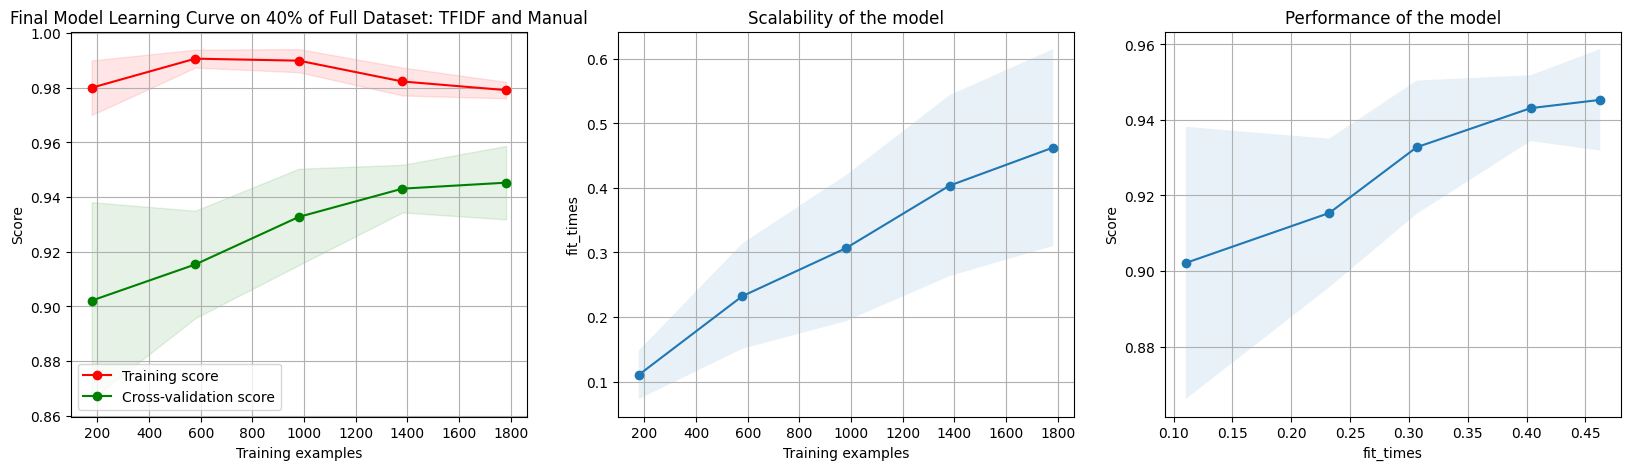

In [38]:
plot_learning_curve(
    best_estimator_spam_model,
    'Final Model Learning Curve on 40% of Full Dataset: TFIDF and Manual',
    X_train_combo,
    y_train,
    scoring = 'f1_macro',
    n_jobs = -1)

### **<font color='Pickle'>Observations</font>**

- **<font color='Pickle'>Learning Curve:</font>**  
  This model still shows indication of **<font color='indianred'>overfitting</font>** even on a larger dataset.
 This is because of the model nearly perfectly fitting the training data. However we can see a consistent increase in the **<font color='Pickle'>CV</font>** scores of the validation data and a slight decrease in the **<font color='Pickle'>training score</font>**, indicating that this model is generalizing ok with the addition of new data up to a point but then tapering slightly downward.

- **<font color='Pickle'>Scalability of the Model:</font>**  
  As with the combo small pipeline we can see a general upward and steady trend of fit times as the training examples increase. The fit times are slightly larger and have higher varaibility as the training examples increase as well. However, even in a limited compute enivronment we were able to only run the model for around 12 minutes using a RandomSearch and acheive good results on the CV.

- **<font color='Pickle'>Performance of the Model:</font>**  
We can see a steady improvement in model performance overall as the fit times increase. The shading around the line also shows us that the variability of the model is decreasing and stabilizing as the fit times increase.

###<font color = "pickle">**Potential Improvements:**
  - Given that the model is <font color = 'indianred'>**overfitting**</font> we can improve the performance further by adding more data and reducing the compexity of the model perhaps by normalizing the trees setting the lambda parameter to a higher value. This could increase the pruning and keep branches with lower output values from having as much of an impact on the model.

------------------------
###<font color = 'Pickle'>**CV and Train Score:**

In [ ]:
# Checking train
print(best_estimator_spam_model.score(X_train_combo,y_train))

# Checking CV
print(complete_grid_spam_model.best_score_)

0.9874326750448833
0.9436366588224157


###<font color = 'Pickle'>**Evaluating on the test set:**

In [43]:
def final_pipeline(text):
  cleaned_text = joblib.load(file_X_test_final)
  X_features,feature_names = featurizer.fit_transform(text)
  X_combo = pd.concat((pd.DataFrame(cleaned_text, columns = ['cleaned_text']),
                       pd.DataFrame(X_features, columns = feature_names)),axis = 1) # concatenates the cleaned_text from test with featurized data based on the row as a key.
  best_estimator_spam_model = joblib.load(file_best_estimator_spam_model)
  predictions = best_estimator_spam_model.predict(X_combo)
  probabilities = best_estimator_spam_model.predict_proba(X_combo)
  return probabilities, predictions

In [44]:
# Final Predictions with probabilities
y_test_prob, y_test_pred = final_pipeline(X_test)


###<font color = 'Pickle'>**Classification Report:**


Test set classification report on unseen data:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.93      0.89      0.91       150

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



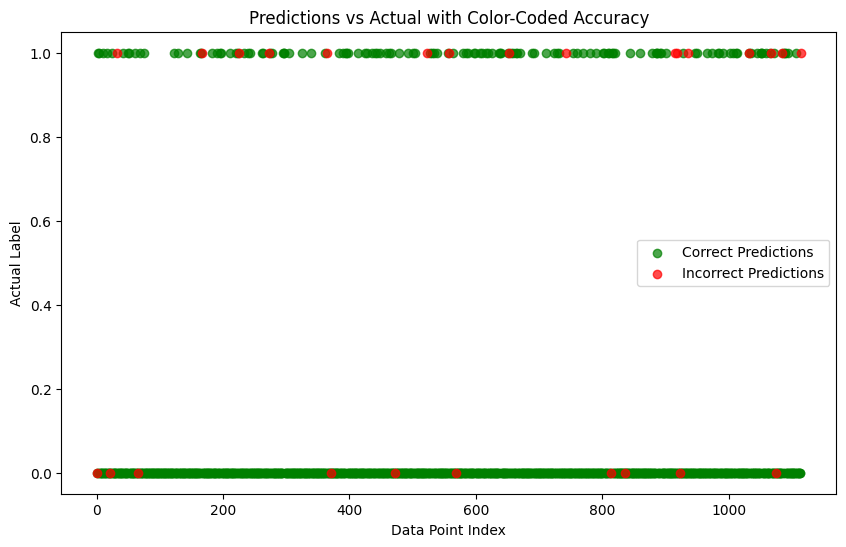

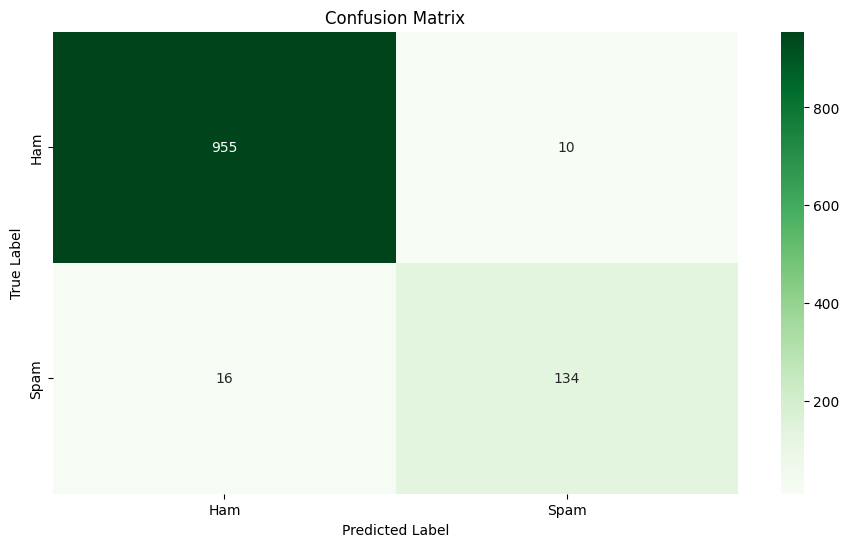

In [48]:
print('\nTest set classification report on unseen data:\n\n',
      classification_report(y_test,y_test_pred))

# Create a scatter plot with color-coded points
plt.figure(figsize=(10, 6))
correct_predictions = y_test == y_test_pred
incorrect_predictions = y_test != y_test_pred

plt.scatter(
    np.where(correct_predictions)[0],
    y_test[correct_predictions],
    color='green',
    label='Correct Predictions',
    alpha=0.7
)
plt.scatter(
    np.where(incorrect_predictions)[0],
    y_test[incorrect_predictions],
    color='red',
    label='Incorrect Predictions',
    alpha=0.7
)

plt.xlabel('Data Point Index')
plt.ylabel('Actual Label')
plt.title('Predictions vs Actual with Color-Coded Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(11.04, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **<font color='Pickle'>Model Interpretation Final Summary</font>**

- **<font color='Pickle'>Class 0 (Ham - Majority Class):</font>**
  - **<font color='Pickle'>Precision: 0.98</font>** – The model correctly identifies 98% of ham emails, making it highly reliable in avoiding false positives for legitimate, non-spam emails.
  - **<font color='Pickle'>Recall: 0.99</font>** – It captures the vast majority of ham emails, missing only 1%, which is excellent coverage.
  - **<font color='Pickle'>F1-Score: 0.99</font>** – The balance between precision and recall is excellent, giving an overall F1-score of 0.99. This shows excellent performance on the majority class.

- **<font color='Pickle'>Class 1 (Spam - Minority Class):</font>**
  - **<font color='Pickle'>Precision: 0.93</font>** – When the model predicts an email as spam, it’s accurate 93% of the time. However, there are still some false positives, meaning 7% of emails flagged as spam are actually ham.
  - **<font color='Pickle'>Recall: 0.89</font>** – It successfully identifies 89% of the actual spam emails, showing strong spam-catching ability, though there’s still room for improvement.
  - **<font color='Pickle'>F1-Score: 0.91</font>** – The balance between precision and recall here gives us an F1-score of 0.91. This reflects solid handling of spam, perhaps increasing the amount of data and making small hyperparameter adjustments will add to the performance.

### **<font color='Pickle'>Overall Takeaway:</font>**

- **<font color='Pickle'>Majority Class (Ham) Performance:</font>** The model is spot-on when it comes to identifying ham emails, with both precision and recall near perfect. Legitimate emails are rarely misclassified, making this a big win for accuracy and user experience.
  
- **<font color='Pickle'>Spam Detection (Minority Class):</font>** The model does a great job catching most spam emails, but with slightly lower precision, meaning some legitimate emails still get flagged as spam. The strong F1-score of 0.91 shows we’ve struck an excellent balance between catching spam and minimizing false positives.

- **<font color='Pickle'>Watch Out for Overfitting:</font>** Despite the high overall performance, the slightly uneven handling of the minority class suggests some potential overfitting. This could impact generalization on unseen data, so it’s worth keeping an eye on as more data is tested.

### **<font color='Pickle'>Performance Metrics Summary:</font>**
- **<font color='Pickle'>Accuracy:</font>** 98%
- **<font color='Pickle'>Macro Average F1-Score:</font>** 0.95
- **<font color='Pickle'>Weighted Average F1-Score:</font>** 0.98


#<font color = 'skyblue'>**Bonus ROC-AUC plot:**

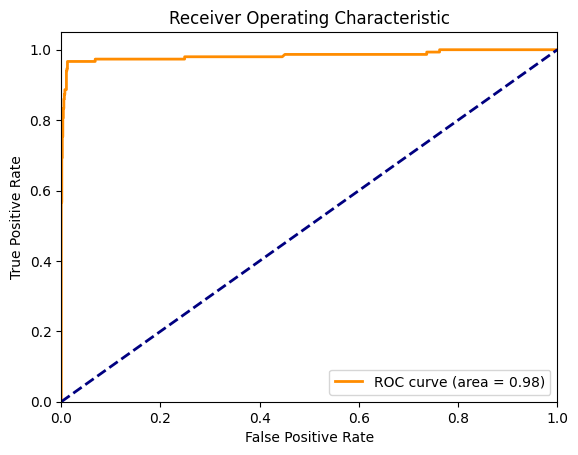

In [47]:
# ROC AUC plot for added experimentation
y_pred_prob = y_test_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()